In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# imports
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import widgets

import scienceplots
plt.style.use(['science','no-latex'])
# plt.style.use(['science'])


# change matplotlib colrormap
cmap = 'magma'
plt.rcParams['image.cmap'] = cmap

# add src to path
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), '../..')))
from src.dynamics import dynamics
from src.linear_response import response, response_regime_metric


In [2]:


def response(W, I):
    """Compute the linear response of a 3-population network.
    assumes that cellular gains are 1."""

    w_ll, w_le, w_lp = W[0, 0], W[0, 1], - W[0, 2]
    w_el, w_ee, w_ep = W[1, 0], W[1, 1], - W[1, 2]
    w_pl, w_pe, w_pp = W[2, 0], W[2, 1], - W[2, 2]

    dI_l, dI_e, dI_p = I[0], I[1], I[2]

    det = np.linalg.det(np.eye(3) - W)
    if det == 0:
        raise ValueError("The matrix (I - W) is singular, cannot compute response.")
    
    R_l = (1/det) * (dI_l*(1 + w_pp - w_ee - w_ee*w_pp + w_ep*w_pe) + 
                     dI_e*(w_le + w_le*w_pp - w_lp*w_pe) + 
                     dI_p*(- w_lp - w_le*w_ep + w_lp*w_ee))

    R_e = (1/det) * (dI_l*(w_el + w_el*w_pp - w_ep*w_pl) + 
                     dI_e*(1 + w_pp - w_ll - w_ll*w_pp + w_lp*w_pl) + 
                     dI_p * (- w_ep - w_el*w_lp + w_ep*w_ll))

    return R_l, R_e


def response_regime_metric(R_l, R_e):
    """ returns the matrix of response regimes:
    0: both positive (Acquisition)
    1: late positive, early negative or zero (Early recall)
    2: late negative or zero, early positive (Late recall)
    3: both negative
    """
    regime = np.zeros(R_l.shape)
    regime[(R_l > 0) & (R_e > 0)] = 0
    regime[(R_l > 0) & (R_e <= 0)] = 1
    regime[(R_l <= 0) & (R_e > 0)] = 2
    regime[(R_l < 0) & (R_e < 0)] = 3
    return regime

In [3]:

def apply_plasticity(W, r, eta, plasticity_rule='hebbian', tau_w=10.0):
    """
    Apply plasticity rule to update weights.
    
    Parameters:
    - W: current weight matrix
    - r: activity vector [r_l, r_e, r_p]
    - eta: learning rate
    - plasticity_rule: 'hebbian', 'oja', or 'bcm'
    - tau_w: weight timescale
    
    Returns:
    - W_new: updated weight matrix
    """
    W_new = W.copy()
    
    if plasticity_rule == 'hebbian':
        # Hebbian: dW_ij = eta * r_i * r_j
        dW = eta * np.outer(r, r) / tau_w
        W_new = W + dW
        
    elif plasticity_rule == 'oja':
        # Oja's rule (normalized Hebbian): dW_ij = eta * r_i * (r_j - W_ij * r_i)
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                dW_ij = eta * r[i] * (r[j] - W[i, j] * r[i]) / tau_w
                W_new[i, j] = W[i, j] + dW_ij
                
    elif plasticity_rule == 'bcm':
        # BCM rule: dW_ij = eta * r_i * r_j * (r_j - theta)
        theta = 0.5  # threshold
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                dW_ij = eta * r[i] * r[j] * (r[j] - theta) / tau_w
                W_new[i, j] = W[i, j] + dW_ij
    
    return W_new


In [4]:

def compute_baseline_activity(W, I_baseline):
    """
    Compute steady-state activity for baseline input.
    Assumes: r_ss = (I - W)^{-1} * I_baseline
    """
    try:
        r_ss = np.linalg.solve(np.eye(W.shape[0]) - W, I_baseline)
        # Apply rectification (rates must be non-negative)
        r_ss = np.maximum(r_ss, 0)
        return r_ss
    except np.linalg.LinAlgError:
        # If singular, return small positive values
        return np.ones(W.shape[0]) * 0.1

In [5]:

def early_vs_late_exc_plastic(J, alpha, beta, g, delta, a, b, c, 
                               eta=0.01, n_steps=10, plasticity_rule='hebbian',
                               preserve_structure=False):
    """
    Compute response with iterative plasticity updates.
    
    Parameters:
    - J, alpha, beta, g, delta: network parameters
    - a, b, c: input perturbations
    - eta: learning rate
    - n_steps: number of plasticity iterations
    - plasticity_rule: type of plasticity
    - preserve_structure: whether to maintain alpha/beta relationships
    """
    # Initial weight matrix
    W = np.array([[J, beta*J, -delta*J],
                  [alpha*J, J, -delta*J],
                  [J, J, -g*J]])
    
    # Input perturbation
    I = np.array([a, b, c])
    
    # Baseline input (zero perturbation)
    I_baseline = np.array([0.0, 0.0, 0.0])
    
    # Iterate plasticity updates
    for step in range(n_steps):
        # Compute baseline activity
        r_baseline = compute_baseline_activity(W, I_baseline)
        
        # Compute response to perturbation
        R_l, R_e = response(W, I)
        
        # Total activity (baseline + response)
        r = r_baseline + np.array([R_l, R_e, 0])
        r = np.maximum(r, 0)  # Rectify
        
        # Apply plasticity
        W = apply_plasticity(W, r, eta, plasticity_rule)
        
        # Optionally preserve structural relationships
        if preserve_structure and step < n_steps - 1:
            # Maintain relative scaling between connections
            W[0, 1] = (W[0, 1] / W[0, 0]) * W[0, 0] if W[0, 0] != 0 else W[0, 1]
            W[1, 0] = (W[1, 0] / W[1, 1]) * W[1, 1] if W[1, 1] != 0 else W[1, 0]
    
    # Final response after plasticity
    R_l, R_e = response(W, I)
    
    return R_l, R_e, W

In [6]:

def plot_response_with_plasticity(J, g, delta, a, b, c, eta=0.01, n_steps=10,
                                  plasticity_rule='hebbian', density=100,
                                  save_fig_location='../results/diff_exc_plastic/'):
    """
    Plot response regimes with plasticity effects.
    Compares pre-plasticity and post-plasticity responses.
    """
    alpha_arr = np.linspace(0.1, 2, density)
    beta_arr = np.linspace(0.1, 2, density)

    # Without plasticity
    R_l_noplastic = np.zeros((len(alpha_arr), len(beta_arr)))
    R_e_noplastic = np.zeros((len(alpha_arr), len(beta_arr)))
    
    # With plasticity
    R_l_plastic = np.zeros((len(alpha_arr), len(beta_arr)))
    R_e_plastic = np.zeros((len(alpha_arr), len(beta_arr)))

    for alpha_idx, alpha in enumerate(alpha_arr):
        for beta_idx, beta in enumerate(beta_arr):
            # Without plasticity
            W = np.array([[J, beta*J, -delta*J],
                         [alpha*J, J, -delta*J],
                         [J, J, -g*J]])
            I = np.array([a, b, c])
            R_l_noplastic[alpha_idx, beta_idx], R_e_noplastic[alpha_idx, beta_idx] = response(W, I)
            
            # With plasticity
            R_l_plastic[alpha_idx, beta_idx], R_e_plastic[alpha_idx, beta_idx], _ = \
                early_vs_late_exc_plastic(J, alpha, beta, g, delta, a, b, c, 
                                         eta, n_steps, plasticity_rule)

    R_eff_noplastic = response_regime_metric(R_l_noplastic, R_e_noplastic)
    R_eff_plastic = response_regime_metric(R_l_plastic, R_e_plastic)

    # Create comparison figure
    fig, axes = plt.subplots(2, 3, figsize=(12, 7), dpi=250)
    
    vmin, vmax = -1, 1
    fs = 12
    
    # Row 1: No plasticity
    im1 = axes[0, 0].imshow(R_l_noplastic, extent=(0.1, 2, 0.1, 2), 
                            origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    axes[0, 0].set_title(r"$R_L$ (No Plasticity)")
    axes[0, 0].set_ylabel(r"$\alpha$", fontsize=fs)
    axes[0, 0].set_xlabel(r"$\beta$", fontsize=fs)
    fig.colorbar(im1, ax=axes[0, 0])
    axes[0, 0].contour(beta_arr, alpha_arr, R_l_noplastic, levels=[0], 
                       colors='white', linewidths=1, linestyles='dashed')

    im2 = axes[0, 1].imshow(R_e_noplastic, extent=(0.1, 2, 0.1, 2), 
                            origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    axes[0, 1].set_title(r"$R_E$ (No Plasticity)")
    axes[0, 1].set_ylabel(r"$\alpha$", fontsize=fs)
    axes[0, 1].set_xlabel(r"$\beta$", fontsize=fs)
    fig.colorbar(im2, ax=axes[0, 1])
    axes[0, 1].contour(beta_arr, alpha_arr, R_e_noplastic, levels=[0], 
                       colors='white', linewidths=1, linestyles='dashed')

    im3 = axes[0, 2].imshow(R_eff_noplastic, extent=(0.1, 2, 0.1, 2), 
                            origin='lower', aspect='auto')
    axes[0, 2].set_title('Regimes (No Plasticity)')
    axes[0, 2].set_ylabel(r"$\alpha$", fontsize=fs)
    axes[0, 2].set_xlabel(r"$\beta$", fontsize=fs)
    cbar = fig.colorbar(im3, ax=axes[0, 2], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Acq', 'Early', 'Late', 'Both-'])

    # Row 2: With plasticity
    im4 = axes[1, 0].imshow(R_l_plastic, extent=(0.1, 2, 0.1, 2), 
                            origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    axes[1, 0].set_title(r"$R_L$ (With Plasticity)")
    axes[1, 0].set_ylabel(r"$\alpha$", fontsize=fs)
    axes[1, 0].set_xlabel(r"$\beta$", fontsize=fs)
    fig.colorbar(im4, ax=axes[1, 0])
    axes[1, 0].contour(beta_arr, alpha_arr, R_l_plastic, levels=[0], 
                       colors='white', linewidths=1, linestyles='dashed')

    im5 = axes[1, 1].imshow(R_e_plastic, extent=(0.1, 2, 0.1, 2), 
                            origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    axes[1, 1].set_title(r"$R_E$ (With Plasticity)")
    axes[1, 1].set_ylabel(r"$\alpha$", fontsize=fs)
    axes[1, 1].set_xlabel(r"$\beta$", fontsize=fs)
    fig.colorbar(im5, ax=axes[1, 1])
    axes[1, 1].contour(beta_arr, alpha_arr, R_e_plastic, levels=[0], 
                       colors='white', linewidths=1, linestyles='dashed')

    im6 = axes[1, 2].imshow(R_eff_plastic, extent=(0.1, 2, 0.1, 2), 
                            origin='lower', aspect='auto')
    axes[1, 2].set_title('Regimes (With Plasticity)')
    axes[1, 2].set_ylabel(r"$\alpha$", fontsize=fs)
    axes[1, 2].set_xlabel(r"$\beta$", fontsize=fs)
    cbar = fig.colorbar(im6, ax=axes[1, 2], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Acq', 'Early', 'Late', 'Both-'])

    fig.suptitle(f'Plasticity: {plasticity_rule}, η={eta}, steps={n_steps}', fontsize=14)
    fig.tight_layout()
    
    if not os.path.exists(save_fig_location):
        os.makedirs(save_fig_location)
    fig.savefig(os.path.join(save_fig_location, 
                f'response_comparison_{plasticity_rule}_eta{eta}_steps{n_steps}.png'), 
                dpi=500)
    plt.show()

Generating plots with Hebbian plasticity...


/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_19176/2290822919.py:97: UserWarning: Glyph 951 (\N{GREEK SMALL LETTER ETA}) missing from font(s) cmr10.
  fig.tight_layout()
/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_19176/2290822919.py:101: UserWarning: Glyph 951 (\N{GREEK SMALL LETTER ETA}) missing from font(s) cmr10.
  fig.savefig(os.path.join(save_fig_location,
/Users/divyansh/miniforge3/envs/mean_field/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 951 (\N{GREEK SMALL LETTER ETA}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


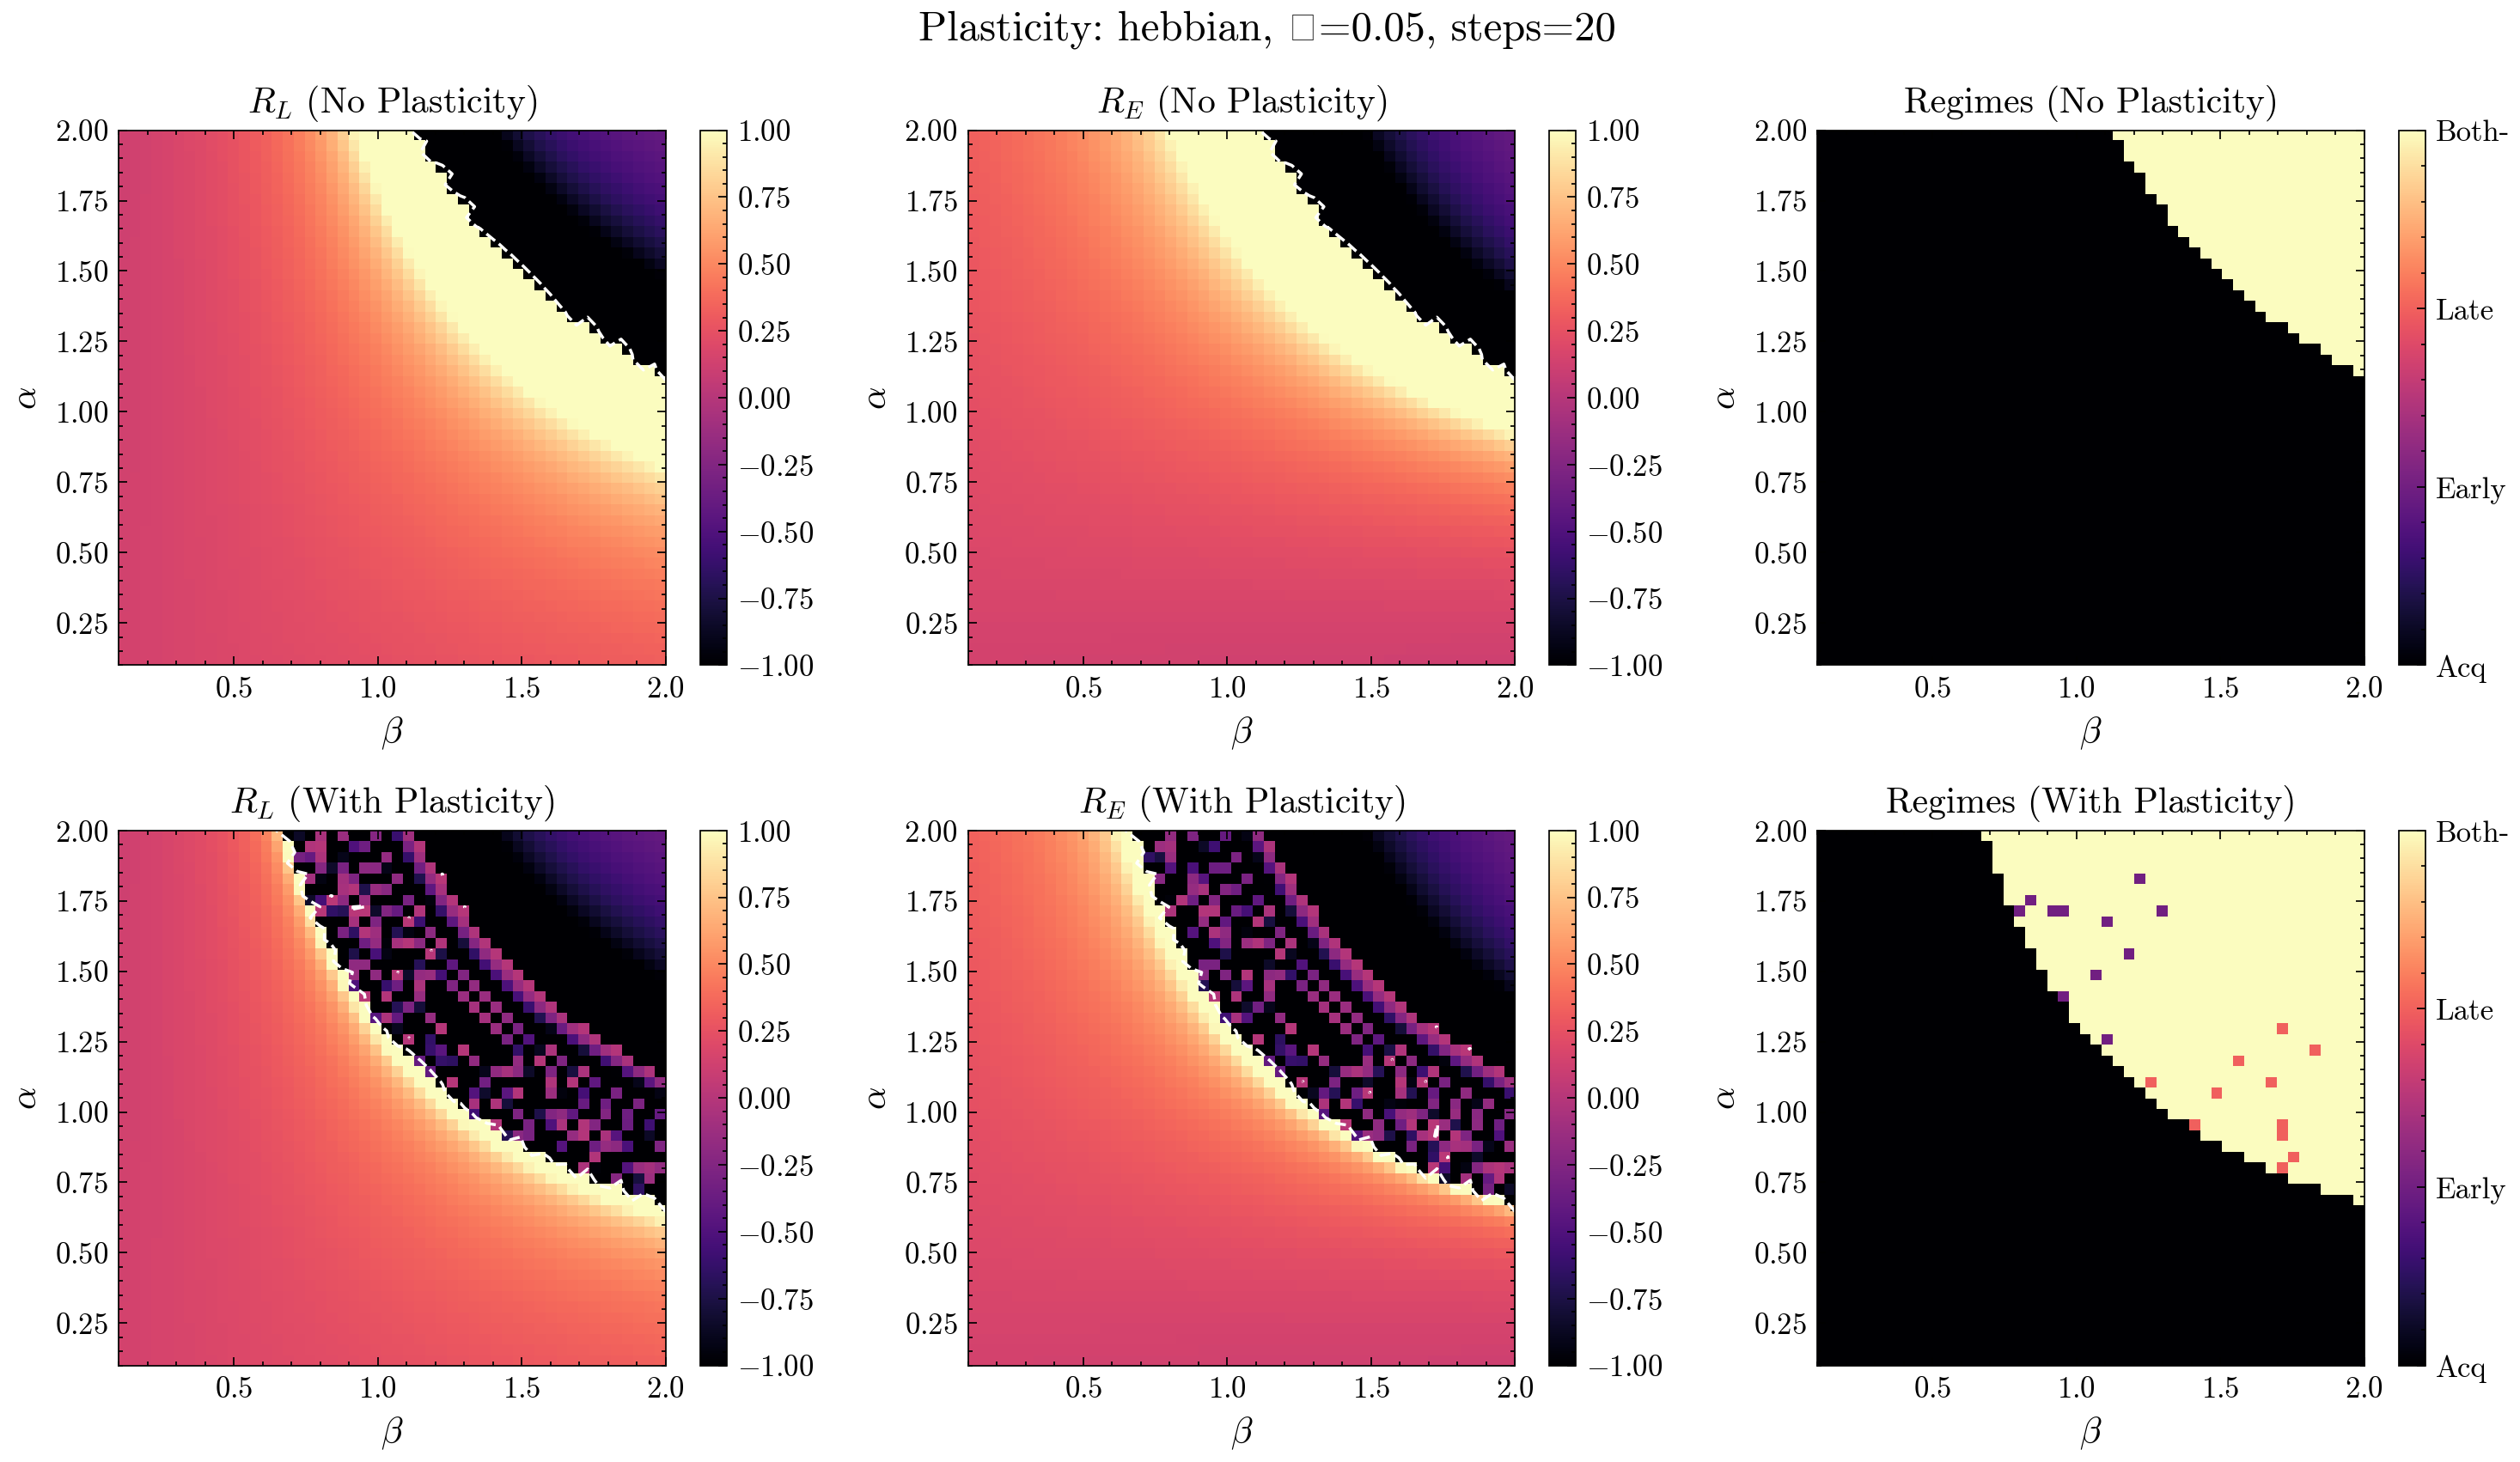

In [7]:
J = 0.5
g = 1.2
delta = 0.8
a, b, c = 0.1, 0.1, 0.0  # Input perturbations

print("Generating plots with Hebbian plasticity...")
plot_response_with_plasticity(J, g, delta, a, b, c, 
                                 eta=0.05, n_steps=20, 
                                 plasticity_rule='hebbian',
                                 density=50)